<a href="https://colab.research.google.com/github/FatemehRajabi/gold-usd-prediction/blob/main/Gold_USD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install yfinance scikit-learn


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Get today's date
today = datetime.date.today()

# Load Gold ETF (GLD) data from Yahoo Finance
data = yf.download('GLD', start='2015-01-01', end=today)

# Flatten MultiIndex
data.columns = data.columns.get_level_values(0)
data.columns.name = None

# Keep only relevant columns
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,112.489998,114.800003,112.320000,114.080002,7109600
2015-01-05,114.779999,116.000000,114.730003,115.800003,8177400
2015-01-06,116.220001,117.500000,115.800003,117.120003,11238300
2015-01-07,116.470001,116.879997,116.169998,116.430000,6434200
2015-01-08,116.449997,116.870003,115.849998,115.940002,7033700


In [4]:
# Simple Moving Averages
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Drop rows with NaNs from indicators
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Volume,SMA_10,SMA_30,RSI_14
Date,,,,,,,,
2015-02-13,118.050003,118.580002,117.790001,117.980003,4108900,119.551000,120.106667,35.742753
2015-02-17,116.400002,116.540001,115.580002,116.010002,7225200,118.910001,120.171001,26.861544
2015-02-18,115.989998,116.529999,114.989998,116.339996,8336000,118.439000,120.189000,29.748256
2015-02-19,116.400002,116.540001,115.739998,115.940002,6528700,117.875000,120.149667,34.165550
2015-02-20,116.099998,116.459999,115.050003,115.279999,6681700,117.224000,120.111334,19.029545


In [5]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Scaled shape:", scaled_data.shape)

Scaled shape: (2546, 8)


In [6]:
# Create sequences (60 timesteps back)
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # shape: (60, 8)
    y.append(scaled_data[i, 3])  # predict the Close price (index 3)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 60, 8)
print("y shape:", y.shape)  # (samples,)

X shape: (2486, 60, 8)
y shape: (2486,)


In [7]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Predicting one value: the Close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0112 - val_loss: 0.0030
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 8.0846e-04 - val_loss: 0.0026
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 7.7374e-04 - val_loss: 0.0018
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.1689e-04 - val_loss: 0.0017
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.3818e-04 - val_loss: 0.0014
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 6.2131e-04 - val_loss: 0.0023
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.8558e-04 - val_loss: 0.0019
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 6.3136e-04 - val_loss: 0.0052
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 6.9480e-04 - val_loss: 0.0027
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.0070e-04 - val_loss: 0.0037
Epoch 12/30
63/63 ━━━━━━━━

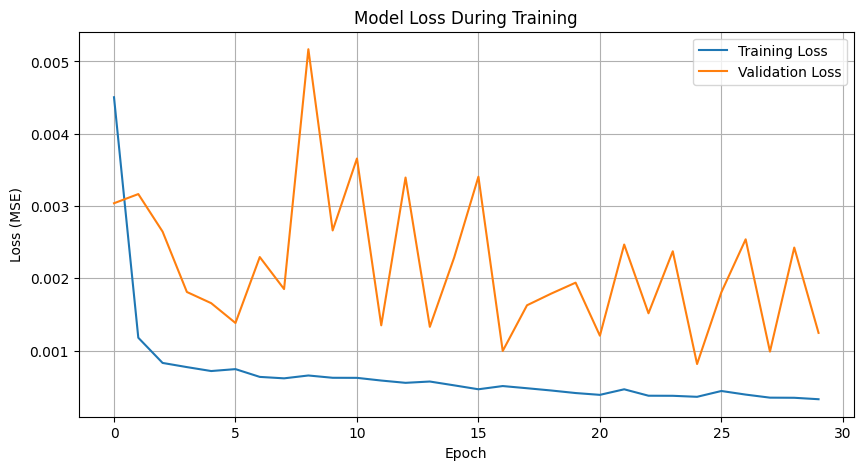

In [10]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
predicted = model.predict(X_test)

# Reverse normalization for 'Close' price only
close_scaler = scaler.scale_[3]
close_min = scaler.min_[3]

predicted_close = predicted / close_scaler + close_min
actual_close = y_test / close_scaler + close_min


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


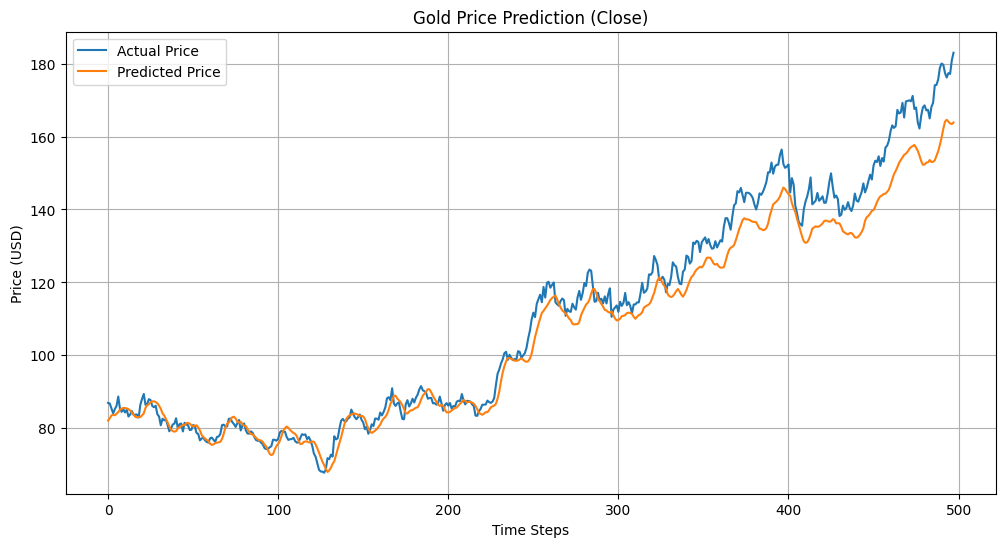

In [12]:
# Plot predicted vs actual Close prices
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Price')
plt.plot(predicted_close, label='Predicted Price')
plt.title('Gold Price Prediction (Close)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
